# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

/Users/muhammaddawood/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


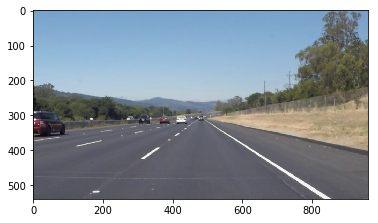

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [164]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # make every line of the form (y2-y1)=m(x2-x1)
    # for every line with x1, x2, y1, y2 there is a slope m
    # with slopes calculated set x1 = 0 and solve for y-intercept
    # notice b = y-mx
    n_right = 0 # lines with positive slope are on the right of the image becasue everything is flipped
    n_left = 0 # lines with negative slope are on the left
    
    sum_m_right = 0
    sum_b_right = 0
    sum_m_left = 0
    sum_b_left = 0
    
    # Top and Bottom in respect to car
    TOP_OF_ROI = 330
    BOTTOM_OF_ROI = 960
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1)/(x2 - x1)
            b = y1-m*x1
            
            #Possible problem if horizontal line, where m=0
            if (m < 0):
                sum_m_left += m
                sum_b_left += b
                n_left += 1
            else:
                sum_m_right += m
                sum_b_right += b
                n_right += 1
    
    #calc avg of lines
    avg_m_right = sum_m_right/n_right
    avg_b_right = sum_b_right/n_right
    avg_m_left = sum_m_left/n_left
    avg_b_left = sum_b_left/n_left
    print(avg_b_left, avg_m_left)
    
    #x=(y-b)/m
    #draw right line
    cv2.line(img, (int(round((TOP_OF_ROI-avg_b_right)/avg_m_right)), TOP_OF_ROI), (int(round((BOTTOM_OF_ROI-avg_b_right)/avg_m_right)), BOTTOM_OF_ROI), color, thickness)
    
    #draw left line
    cv2.line(img, (int(round((TOP_OF_ROI-avg_b_left)/avg_m_left)), TOP_OF_ROI), (int(round((BOTTOM_OF_ROI-avg_b_left)/avg_m_left)), BOTTOM_OF_ROI), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

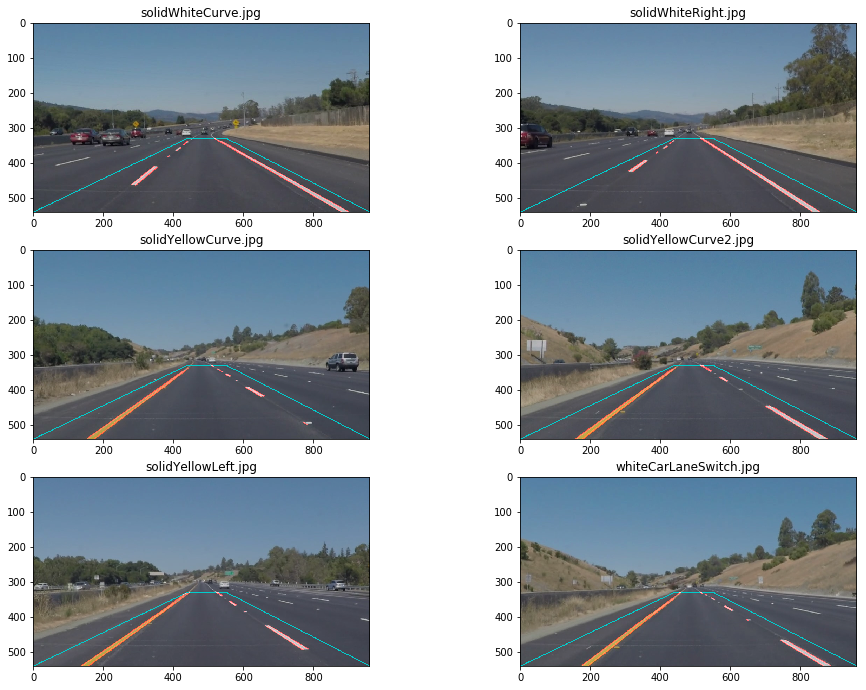

In [112]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
files = os.listdir("test_images/")

# define paramaters
KERNEL_SIZE = 3 # kernel size for Gaussian smoothing

LOW_THRESHOLD = 75 # low threshold for Canny edge
HIGH_THRESHOLD = 150 # high threshold for Canny edge

RHO = 2 # distance resolution in pixels of the Hough grid
THETA = np.pi/180 # angular resolution in radians of the Hough grid
THRESHOLD = 50     # minimum number of votes (intersections in Hough grid cell)
MIN_LINE_LENGTH = 3 # minimum number of pixels making up a line
MAX_LINE_GAP = 5    # maximum gap in pixels between connectable line segments

fig = plt.figure(figsize=(16, 16))

for index,file in enumerate(files):
    # load image
    image = mpimg.imread('test_images/'+file)
    
    # apply grayscale, smoothing, and find edges
    gray_image = grayscale(image)
    smooth_image = gaussian_blur(gray_image, KERNEL_SIZE)
    edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
    
    # apply four sided polygon mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (550, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # apply hough transfrom to find lines
    line_image = hough_lines(masked_edges, RHO, THETA, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)
    
    #combine images
    image = cv2.polylines(image, vertices, True, (0,255,255),2)
    lined_up_image = weighted_img(line_image, image)
    fig.add_subplot(4,2,1+index)
    plt.title(file)
    plt.imshow(lined_up_image)
    mpimg.imsave('test_images_output/'+file, lined_up_image)
    
plt.show() 
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [160]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [161]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # apply grayscale, smoothing, and find edges
    gray_image = grayscale(image)
    smooth_image = gaussian_blur(gray_image, KERNEL_SIZE)
    edges = canny(smooth_image, LOW_THRESHOLD, HIGH_THRESHOLD)
    
    # apply four sided polygon mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (550, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # apply hough transfrom to find lines
    line_image = hough_lines(masked_edges, RHO, THETA, THRESHOLD, MIN_LINE_LENGTH, MAX_LINE_GAP)
    
    #combine images
    result = weighted_img(line_image, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [165]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

655.791240428 -0.734659114991
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  3%|▎         | 7/222 [00:00<00:03, 64.22it/s]

655.791240428 -0.734659114991
638.264396998 -0.697829083884
650.823473228 -0.718849223191
650.782206463 -0.721344079897
655.173530953 -0.735853050935
632.198412698 -0.674437830688
642.211349925 -0.701310331825
647.617676768 -0.715651315651
644.254677003 -0.708837209302
647.772636373 -0.710577977245
659.531347819 -0.736962343212
654.905995007 -0.724632085992


654.735209626 -0.727215085136
646.687637548 -0.713141955588



 10%|▉         | 22/222 [00:00<00:03, 65.39it/s]

640.819297491 -0.70093966441
638.579325919 -0.69923393175
639.985507246 -0.69799658994
645.905982906 -0.714743589744
634.728897059 -0.684301470588
641.660091646 -0.697298711584
645.126643232 -0.704231316669
647.664451993 -0.711139603597
659.812103098 -0.738873322969
656.152492369 -0.733692581365
654.80395875 -0.730266740469
653.734144906 -0.727556218572
648.805194548 -0.717940829635
653.240841715 -0.723012362812



 17%|█▋        | 37/222 [00:00<00:02, 68.06it/s]

653.808325792 -0.715022624434
644.976415148 -0.70424260005
647.758838384 -0.714670902574
646.449887387 -0.712274774775
649.056031746 -0.718134920635
649.956409022 -0.718680112774
642.494810745 -0.700702075702
645.01306718 -0.705181045161
659.338657391 -0.742875152781
659.45099474 -0.739617790101
664.11354253 -0.753822835496
650.13633268 -0.716850694754
655.943146666 -0.740467609969
650.04053288 -0.722467876039



 20%|█▉        | 44/222 [00:00<00:02, 65.66it/s]

663.838848008 -0.757275890591
639.586914255 -0.699899369636
651.597708254 -0.730260809387
634.938238095 -0.688904761905
654.770833333 -0.738815789474
640.925215414 -0.709022813144
640.495660377 -0.706289308176
651.431719762 -0.733872592578



 25%|██▌       | 56/222 [00:00<00:03, 47.62it/s]

649.231484945 -0.72710074938
647.848267317 -0.728241347429
631.759567324 -0.678754730732
631.3583878 -0.680283224401
639.432831513 -0.703050948866
629.782438282 -0.67939042939
634.470419918 -0.686541839803
632.099357544 -0.677163501041


634.478943571


 30%|██▉       | 66/222 [00:01<00:03, 43.77it/s]

 -0.683735854788
635.1453892 -0.692985149163
631.248703487 -0.68113391182
635.88430552 -0.690921794072
633.108488591 -0.685234833318
620.982704356 -0.651391830001
621.021073647 -0.647589470571
617.930738004 -0.643865170589
625.96992913 -0.673173264907
619.809835194


 32%|███▏      | 71/222 [00:01<00:03, 44.54it/s]

 -0.656073896863
628.645847718 -0.674232279349
626.535947712 -0.671802054155
625.612472653 -0.665808429921
630.74059688 -0.683804932229
620.955686693 -0.654827956553
628.566980743 -0.672518965194
625.456987824 -0.667031613529
622.977338867 -0.660038731627


 34%|███▍      | 76/222 [00:01<00:03, 43.46it/s]


628.596974175 -0.679852239294



 39%|███▊      | 86/222 [00:01<00:03, 44.60it/s]

621.823299408 -0.659988031272
604.478553922 -0.618341503268
627.179115201 -0.675127535422
625.192007596 -0.670960785246
614.958188469 -0.645063740403
636.075342263 -0.698267746859
611.363228445 -0.635456175081
614.644302734 -0.641102620854
609.481976978 -0.628195228487
613.339975561 -0.641433966222



 41%|████      | 91/222 [00:01<00:03, 42.89it/s]

629.136990077 -0.677734935438
630.787129087 -0.683342783343
609.401477833 -0.616174055829
635.631428571 -0.689404761905
618.053303046 -0.640612562041
615.046231546 -0.638820901321
608.962032472 -0.622994239825
604.328240772 -0.617435850985



 43%|████▎     | 96/222 [00:01<00:02, 43.06it/s]

612.575771416 -0.633530366442



 45%|████▌     | 101/222 [00:02<00:02, 43.17it/s]

632.626015376 -0.68615173027
618.941505238 -0.651338931134
617.06226268 -0.643556039055
618.09509953 -0.657962533222
616.389878354 -0.642960644007
630.338207384 -0.675981711525
606.79047619 -0.614285714286
618.121483159 -0.642619807093


631.063364109 -0.674952157126
638.361769497


 50%|█████     | 111/222 [00:02<00:02, 42.04it/s]

 -0.69199502846
643.737303768 -0.709805075877
637.142977636 -0.690307499518
625.324042443 -0.659541062802
636.633566776 -0.686279952747
635.063242238 -0.687841851008
630.655351375 -0.672855523582
628.477521645 

-0.670497835498
629.342691198 -0.66968975469
626.101859319 -0.665165770609



 55%|█████▍    | 121/222 [00:02<00:02, 41.46it/s]

641.674681201 -0.701579139814
629.126617681 -0.674192787163
625.232127396 -0.662764616336
619.256973002 -0.65081067528
622.965073446 -0.655331361207
626.722084658 -0.661463824237
629.843740895 -0.669827318957
622.548950394 -0.652369552472
634.272753585 -0.679498571178



 59%|█████▉    | 131/222 [00:02<00:02, 43.30it/s]

634.396346677 -0.676870641949
640.85968652 -0.695339602926
647.832172404 -0.711336410362
650.531068752 -0.714312479635
641.366632791 -0.694004065041
636.247062597 -0.676126354021
660.819728353 -0.73558007923
645.943635796 -0.697629352459
661.992441381 -0.739295363798



 64%|██████▍   | 142/222 [00:02<00:01, 46.27it/s]

642.36508403 -0.69246853788
649.38754524 -0.719344220127
637.19939723 -0.684699065318
639.637541957 -0.692376011669
641.801715686 -0.699479847495
643.548869276 -0.700112320475
652.162217102 -0.717967229903
647.613165266 -0.704726890756
651.876870748 -0.713605442177
632.845263158 -0.662647527911
649.085017854 -0.708566775731


 69%|██████▉   | 153/222 [00:03<00:01, 48.64it/s]


655.154459059 -0.719993492598
638.128159041 -0.681305010893
658.696370434 -0.734180012082
648.487316196 -0.712021909828
646.981064261 -0.704824880737
670.157636566 -0.758305462653
657.474725003 -0.724852030377
651.582314744 -0.714890501655
659.491567649 -0.733264761643
648.57196143 -0.707220268158
639.312205125


 71%|███████   | 158/222 [00:03<00:01, 47.29it/s]

 -0.682840693752
660.306615917 -0.737010149896
649.987026832 -0.711554956408
663.723950451 -0.748569277298
660.737883748 -0.735495198498
660.982687705 -0.733471794189
664.777095192 -0.738595392011
670.378354978 -0.752294372294
679.594373219 -0.773326210826
674.102462121


 74%|███████▍  | 164/222 [00:03<00:01, 48.86it/s]

 -0.759706439394
674.86599681 -0.76101010101
676.01401489 -0.762162590113



 79%|███████▉  | 175/222 [00:03<00:00, 51.02it/s]

664.911834734 -0.733169934641
675.028018581 -0.759677849109
676.727498813 -0.764268755935
673.880961154 -0.758746256064
678.071219395 -0.776877134253
679.237581058 -0.766921806862
688.69568547 -0.798745378229
670.314664502 -0.748241341991
686.448601399 -0.789160839161
697.808050516 -0.812408227548
697.259340959 -0.810914643635
709.66569378 -0.842440191388



 82%|████████▏ | 181/222 [00:03<00:00, 51.53it/s]

713.557286339 -0.853327317817
691.345376182 -0.804044168485
691.22955832 -0.80035629064
694.288350145 -0.808794569933
688.340158667 -0.79803571505
687.27505697 -0.794752147347
698.878916357 -0.828537125642
680.026477146 -0.775487736901



 84%|████████▍ | 187/222 [00:03<00:00, 52.81it/s]

705.65375 -0.837916666667
686.346498363 -0.797071610715
672.512702313 -0.764275964276
674.613048063


 87%|████████▋ | 193/222 [00:03<00:00, 51.93it/s]

 -0.768678543679
684.237389755 -0.792948554189
670.576849199 -0.757604001414
681.752804233 -0.780899470899
690.036686713 -0.796436188559
685.434449614 -0.780956549616
687.643977326 -0.790606484489
676.468030647 -0.764395657253



 90%|████████▉ | 199/222 [00:04<00:00, 52.78it/s]

683.792753623 -0.787474120083
698.648148148 -0.824074074074
692.85250232 -0.804618895909
690.278167421 -0.803905408317



 92%|█████████▏| 205/222 [00:04<00:00, 51.42it/s]

703.420150334 -0.838228779018
687.372372277 -0.796971742203
685.900277974 -0.791397201879
691.218150322 -0.809121416898
688.489621142 -0.799511428743
686.582125842 -0.797847622687
691.162237583


 95%|█████████▌| 211/222 [00:04<00:00, 50.51it/s]

 -0.809603814644
681.535370358 -0.789778135834
676.116977226 -0.772256728778
678.086231884 -0.774577294686
673.136520737 -0.756912442396



 98%|█████████▊| 217/222 [00:04<00:00, 51.49it/s]

691.388379695 -0.802949102406
669.35047619 -0.750714285714
690.257082833 -0.796149888527
676.285395274 -0.765877816685
684.047141948 -0.78256002712
688.342131566 -0.793847886185
673.616330625 -0.765189809217



100%|█████████▉| 221/222 [00:04<00:00, 49.11it/s]

677.063547311 -0.767484169895
693.181875118 -0.807205363333
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.2 s, sys: 1.42 s, total: 4.62 s
Wall time: 5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [166]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [167]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

608.918468224 -0.617190821106
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 6/682 [00:00<00:12, 53.57it/s]

608.918468224 -0.617190821106
613.255450279 -0.624340316005
615.808337522 -0.630345181753
624.102502334 -0.650467425123
614.637773297 -0.635593682059
617.983906335 -0.633914240964
622.322325673 -0.6431376048
629.557317942 -0.65866174899
633.189176422 -0.673506402457
637.674027792 -0.683357579559


626.610379781 -0.654717715147
625.615241591 -0.661697475923
638.78490374 -0.683963814501



  3%|▎         | 19/682 [00:00<00:12, 54.71it/s]

635.049418306 -0.671394112451
640.383910752 -0.692110151771
642.623113942 -0.696658225594
641.677111815 -0.691347436579
641.799583255 -0.695376451654
639.242904551 -0.692290114313
642.523096391 -0.694434886756
645.366815957 -0.703186332984
647.678463245 -0.711664777475
632.765320799 -0.680764135541
640.893012431 -0.695106311028
650.688857767 -0.714229545191



  5%|▍         | 31/682 [00:00<00:12, 52.57it/s]

657.523446764 -0.731957406029
658.031343251 -0.735377504883
653.630461835 -0.719521236342
651.669056694 -0.72199145553
641.216829556 -0.697304591369
648.52331778 -0.719352094923
648.612878623 -0.714487878575
660.238578783 -0.744476991309
662.367361448 -0.752893288817
663.33674542 -0.755593938524
656.72535695 -0.737603363906



  6%|▋         | 43/682 [00:00<00:11, 54.33it/s]

666.824113231 -0.759619001668
656.227984532 -0.738580111122
658.963541996 -0.749004131742
653.958677834 -0.73839078183
655.659820875 -0.743472409972
665.938950201 -0.76689109628
658.697383667 -0.748786177178
657.16109114 -0.746381562231
653.562783453 -0.73469216046
652.799634513 -0.732946030171
650.703887236 -0.725419403918



  7%|▋         | 49/682 [00:00<00:12, 49.20it/s]

655.252422049 -0.734145750704
647.229332144 -0.718399489651
646.097766412 -0.718008305899
649.161291034 -0.730161987534
649.174352251 -0.733672465898
649.574312936 -0.725757800346



  8%|▊         | 54/682 [00:01<00:13, 46.67it/s]

657.00870466 -0.744528271492
648.596783794 -0.723065897688
641.182796414 -0.693803244338
652.275318432 -0.72976097319



  9%|▊         | 59/682 [00:01<00:13, 46.76it/s]

649.4875 -0.725
654.572646521 -0.740238889265
643.604408717 -0.709562215033
651.817239416 -0.729493005487
642.572866723 -0.713094585785
640.691368173

 -0.704697809931



  9%|▉         | 64/682 [00:01<00:14, 44.10it/s]

641.23109701 -0.714900647544
639.707936481 -0.706085803933



 10%|█         | 69/682 [00:01<00:14, 41.36it/s]

641.92022042 -0.714289350585
640.571368519 -0.707223326865
642.24862147 -0.708151839743
643.879791394 -0.704828464155
646.983278679 -0.715367321909
650.45474243 -0.722045006079


652.848625267 -0.728066845239
656.616358483 -0.739222404668



 12%|█▏        | 79/682 [00:01<00:15, 38.94it/s]

647.785215361 -0.714799990216
642.496540147 -0.705081090551
643.303068954 -0.704587263265
644.737898766 -0.707391285677
652.955144471 -0.730104609632
648.997925035 -0.718848716543
645.99287295 -0.716716759748
650.309181611 -0.724303706207



 12%|█▏        | 84/682 [00:01<00:15, 39.31it/s]

639.045717749 -0.701009042349
639.892834127 -0.701634091639
637.511539964 -0.697256171772
636.913461207 -0.698578761867
644.762938444 -0.714213394121
642.670172132 -0.706078869922
642.518683164 -0.705043215938
634.432205962 -0.679128026837



 13%|█▎        | 89/682 [00:01<00:14, 41.33it/s]

634.349762247 -0.677791012434
633.787015048


 14%|█▍        | 94/682 [00:02<00:14, 41.45it/s]

 -0.692567363346
634.988774615 -0.683257871239
638.007213277 -0.69419654416
639.872174498 -0.688054418047
638.295884189 -0.683911819365
638.829690043 -0.683967718387
645.747802654 -0.70486626797
639.442629756 -0.686812422132



 15%|█▍        | 99/682 [00:02<00:14, 41.62it/s]

645.113334667 -0.704385973859
647.53397407


 15%|█▌        | 104/682 [00:02<00:13, 42.43it/s]

 -0.712794361824
642.809493218 -0.69401378717
639.625454169 -0.698522022824
630.742240157 -0.671170477666
641.465008586 -0.700550637445
640.134185589 -0.698623861858
642.922283014 -0.701561517646
642.209517369 -0.701762897657
635.16580423 -0.684356480748



 16%|█▌        | 109/682 [00:02<00:13, 42.77it/s]

637.756878649 -0.688527875011



 17%|█▋        | 114/682 [00:02<00:13, 42.60it/s]

640.085371124 -0.690410223638
646.173052627 -0.701996982098
637.441633118 -0.681213079037
644.06160246 -0.698965272984
638.690187815 -0.685858207952
640.802468832 -0.691442006998
641.460663617 -0.69406912654
646.829734808 -0.704858659267


639.379943618 -0.690034236211



 18%|█▊        | 124/682 [00:02<00:13, 42.32it/s]

646.760968713 -0.706047465693
649.647379964 -0.713644607835
648.514894575 -0.716313199772
641.880359249 -0.693540432637
639.494756612 -0.683789824815
646.642107203 -0.706694352695
639.017298589 -0.688151080782
646.903972025 -0.710171430604
646.458752961 -0.710272861419
654.946652442


 20%|█▉        | 134/682 [00:02<00:12, 42.63it/s]

 -0.721989269089
645.140876302 -0.705455461099
643.582826777 -0.699888369337
650.495281253 -0.714325281469
648.390014578 -0.713696850035
644.717159374 -0.709650093252
653.929972028 -0.720063435935
644.3663742 -0.698307948776
644.136541092 -0.695842695552
639.379709211 -0.687398444005



 21%|██▏       | 145/682 [00:03<00:11, 45.34it/s]

642.831059862 -0.700502389924
650.800463996 -0.712115608985
643.722131872 -0.694088933187
637.791722944 -0.68422902314
643.596116354 -0.697916357057
648.150543157 -0.706382474843
635.36019594 -0.677948945662
645.283694102 -0.69896400615
640.348085578 -0.679998706084
642.311055456 -0.698321328091



 22%|██▏       | 150/682 [00:03<00:11, 44.47it/s]

643.283839018 -0.700655005036
645.76882037 -0.700495344532
644.33771029 -0.696861079242
644.288485904 -0.693874722838
634.376842533 -0.671915957971
643.758720841 -0.693749553745
648.030740482 -0.692504158798



 23%|██▎       | 155/682 [00:03<00:12, 42.47it/s]

654.304430561 -0.719588690489
652.189349026 -0.701897129662



 23%|██▎       | 160/682 [00:03<00:12, 42.18it/s]

653.673122966 -0.706164546463
652.375436465 -0.702489940795
649.160364317 -0.698133474722
655.812525768 -0.708592435678
659.040391429 -0.716831488184
657.694717881 -0.71167225947


666.623244599 -0.736791755872
659.739708339 -0.717868811102



 25%|██▍       | 170/682 [00:03<00:12, 40.63it/s]

658.615982922 -0.71232271344
657.241980316 -0.717337473851
657.084678868 -0.716293836636
657.79622818 -0.721989680759
660.560565502 -0.719183358018
666.288413686 -0.735040000166
668.126553065 -0.741213112044
663.033980917 -0.723150073551
666.924806513 -0.736768311562
666.378662027 -0.735133170091



 26%|██▋       | 180/682 [00:04<00:12, 41.39it/s]

668.231205895 -0.738526286661
676.842754911 -0.767135511892
680.588600423 -0.769236186115
672.537221071 -0.745002356985
679.607132589 -0.766834178399
677.374225981 -0.76021898733
676.166059431 -0.756374656403
675.855519368 -0.759107775015
683.555673853 -0.776641342375



 27%|██▋       | 185/682 [00:04<00:11, 42.85it/s]

683.506108653 -0.772564291313
675.301286021 -0.757000139507
678.012365219 -0.762524960654
680.922008468 -0.767840920085
677.821695208 -0.759429270889
689.210974269 -0.791475891265



 28%|██▊       | 190/682 [00:04<00:11, 42.27it/s]

678.24161993 -0.763771330966
680.619312117 -0.77176405982
690.069509524 -0.79737022377



 29%|██▊       | 195/682 [00:04<00:11, 42.70it/s]

680.250468816 -0.766290806591
676.881248197 -0.763760193636
688.831804673 -0.797552999204
680.319567294 -0.778089778264
679.249288304 -0.772238610455
683.671281751 -0.782127502091
675.156211316 -0.770839458179



 29%|██▉       | 200/682 [00:04<00:11, 42.39it/s]

676.920060082 -0.767054198306



 30%|███       | 205/682 [00:04<00:11, 39.88it/s]

656.76850356 -0.658977667388
665.563682795 -0.741200912958
675.706733082 -0.770303758624
673.532055277 -0.76322513634
672.499863249 -0.758249454269
670.092614098 -0.752631383015
671.869796808 -0.75915477302



 31%|███       | 210/682 [00:04<00:11, 41.30it/s]

668.245464795 -0.749821243336
672.943669828 -0.763964622995
666.426648056 -0.742613022687



 32%|███▏      | 215/682 [00:04<00:11, 41.62it/s]

662.210290426 -0.739389396619
666.217436078 -0.749264983634
665.700647691 -0.746289536922
656.898409901 -0.721286929863
655.899384389 -0.721592471572
663.775027585 -0.73445369884


661.755428942 -0.737900012073
659.293240407 -0.732889740171
665.112562458 -0.745390041015
655.785736496


 33%|███▎      | 225/682 [00:05<00:10, 41.62it/s]

 -0.72381704305
661.862354248 -0.734138238769
667.90419682 -0.748979423486
659.803675369 -0.732556250023
650.040569686 -0.70291097439
654.719314586 -0.713921730221


653.045126701 -0.717598321342
650.526760083 -0.712824359649
648.498000032 -0.692319639409
662.560745804 -0.742696587597



 34%|███▎      | 230/682 [00:05<00:10, 42.47it/s]

658.635302065 -0.731744870465
661.650406171 -0.735846016888
653.518018779 -0.719369312754
647.287261288 -0.712402388707
652.377821927 -0.715617598996



 34%|███▍      | 235/682 [00:05<00:10, 41.33it/s]

647.770223368 -0.707451538391
651.452019429 -0.719838512793
646.718387974 -0.707961069659
648.423808691 -0.711006411032



 35%|███▌      | 241/682 [00:05<00:10, 43.05it/s]

647.900149326 -0.709035923872
646.079518539 -0.705948776346
645.286574573 -0.700165848884
644.343964825 -0.701008717734
651.548312953 -0.713365213868
643.384166938 -0.694449061587



 36%|███▌      | 246/682 [00:05<00:10, 42.17it/s]

650.626277489 -0.712657005235
662.543034856 -0.738873507086
657.304578641 -0.721256163717



 37%|███▋      | 251/682 [00:05<00:09, 43.30it/s]

657.075274075 -0.72594776623
658.942280485 -0.731141533239
656.822658494 -0.725950128413
660.447787242 -0.737785516415
655.041493521 -0.722677765715
649.295922817 -0.709368152141



 38%|███▊      | 256/682 [00:05<00:09, 43.78it/s]

654.0626038 -0.718484412774
674.11519397 -0.772575364052
660.315099187 -0.737681732075



 38%|███▊      | 262/682 [00:05<00:09, 45.70it/s]

653.895077363 -0.723027120238
654.630273696 -0.722944396428
658.845128146 -0.734543862074
664.297531451 -0.745017605387
663.735931028 -0.745688869273
671.489820931 -0.762137943037
655.686018699 -0.723587371856
653.289275876 -0.710158076025



 39%|███▉      | 267/682 [00:06<00:08, 46.90it/s]

653.018356973 -0.716640473432
652.7592014 -0.720647509856
651.751979656 -0.71030867644



 40%|████      | 273/682 [00:06<00:08, 48.03it/s]

652.197013516 -0.714837729154
652.174113715 -0.718300500468
652.409937362 -0.712459793465
653.26570224 -0.714589662637
651.840700661 -0.710282999137
656.096644379 -0.716660505916
659.089740391 -0.721520472955


652.783616147 -0.710268970466
649.613726615 -0.707690696692
653.751321563 -0.715320655348



 41%|████      | 278/682 [00:06<00:08, 45.19it/s]

653.046167705 -0.710143289972
658.618721767 -0.723510139092
653.086293108 -0.7077970923
657.258514345 -0.718468477389
631.301321144 -0.650316030633
652.784080741 -0.706357917497



 41%|████▏     | 283/682 [00:06<00:08, 44.63it/s]

655.127172634 -0.718787751031
665.999762218 -0.742633117003
653.357604956 -0.709320287223
657.58517556 -0.726070841578



 42%|████▏     | 289/682 [00:06<00:08, 46.30it/s]

663.168716824 -0.733911881654
666.425727359 -0.738972333845
657.275279202 -0.696951410852
645.838739091 -0.643894508265
654.800531844 -0.713752275051



 43%|████▎     | 294/682 [00:06<00:09, 41.90it/s]

661.001555726 -0.728820240572
663.033504011 -0.734636275243
664.263932322 -0.741452350784



 44%|████▍     | 299/682 [00:06<00:09, 42.38it/s]

658.600019689 -0.728390642684
665.73725585 -0.744442436323
667.936503607 -0.74988182275
664.353662256 -0.740360391766
680.383522361 -0.774346220708
661.255184089 -0.733279495836
662.18538435 -0.733316383448



 45%|████▍     | 304/682 [00:06<00:08, 43.95it/s]

662.812599326 -0.73880359461
660.378729368 -0.734583456215
663.748249748 -0.738757193918



 45%|████▌     | 309/682 [00:07<00:08, 45.35it/s]

662.053530398 -0.730924816716
657.218853139 -0.738449523819
658.271927783 -0.736062687877
663.807212785 -0.745169824984
663.96695555 -0.749356219977
654.420550999 -0.727526821552
648.500524168 -0.712057827682



 46%|████▌     | 314/682 [00:07<00:07, 46.11it/s]

652.790039442 -0.723347649035
653.039473334 -0.718674987172
659.677385991 -0.742228219786



 47%|████▋     | 319/682 [00:07<00:07, 45.41it/s]

651.314585946 -0.71856331747
655.203219892 -0.728454683868
656.809431022 -0.73188401251
651.861253821 -0.717159101871
655.155003447 -0.728399068488
667.2128052 -0.759324902975
659.961293512 -0.739803896188



 48%|████▊     | 325/682 [00:07<00:07, 46.85it/s]

652.635983629 -0.717489185633
654.499759663 -0.725442790381
649.76948961 -0.704788936742



 48%|████▊     | 330/682 [00:07<00:07, 47.20it/s]

650.879986412 -0.713646707971
649.466328334 -0.711431302723
659.862456169 -0.734505014665
650.538783581 -0.708620020347
646.250249324 -0.714951692183
647.087159193 -0.709066388556
640.952961718 -0.700584585225



 49%|████▉     | 335/682 [00:07<00:07, 47.97it/s]

642.974113925 -0.703459757839
642.708717869 -0.696361412677
649.011734011 -0.704272108058
641.912288797


 50%|████▉     | 340/682 [00:07<00:07, 46.92it/s]

 -0.692917862917
638.062313891 -0.682627084697
636.306856355 -0.678044789517
640.043112453 -0.692732217973
637.036269136 -0.683877321946
642.083129703 -0.695234380659
636.745323961 -0.684800253386



 51%|█████     | 345/682 [00:07<00:07, 47.41it/s]

640.409859559 -0.694162039792
637.520746807 -0.684902387152
639.668472746 -0.689422153738
638.158849123 -0.68734974635



 51%|█████▏    | 350/682 [00:07<00:07, 46.28it/s]

639.443855352 -0.689636522422
641.733400118 -0.690377728309
645.233938433 -0.69753849759
643.616174251 -0.686600278312
651.018229471 -0.71100925101
640.940572116 -0.684429009768



 52%|█████▏    | 356/682 [00:07<00:06, 48.50it/s]

652.432428511 -0.716024470873
637.639442454 -0.673769367578
653.24768905 -0.718708198155
652.082724885 -0.726530996328
652.037355772 -0.718195680452



 53%|█████▎    | 361/682 [00:08<00:06, 48.40it/s]

640.251525423 -0.686802122836
650.874137828 -0.716276862091
659.745336841 -0.739643542454
665.23079119 -0.751089332919
652.287564712 -0.723086346534
651.678451804 -0.717636215234



 54%|█████▍    | 367/682 [00:08<00:06, 49.18it/s]

662.304292894 -0.744853620756
656.1468437 -0.726700281838
661.989605204 -0.743672623933
653.779025007 -0.723522589703



 55%|█████▍    | 373/682 [00:08<00:06, 50.80it/s]

653.660358023 -0.725041416719
658.500342524 -0.737515567819
652.31438819 -0.727316973294
651.947504265 -0.723445053176
652.621949437 -0.648150246993
655.749147734 -0.740834148763
659.099296366 -0.743561054102


647.390321735 -0.709671646127
655.625596909 -0.739783763536
649.908510212 -0.726506370671
650.907809684 -0.734162367204



 56%|█████▌    | 379/682 [00:08<00:05, 50.51it/s]

650.858028073 -0.729936380659
630.662176428 -0.679719376803
640.501056436 -0.70149095828
636.336065102 -0.687418779852
645.078550008 -0.708674764674
640.824870806 -0.699945858172
639.993152068 -0.694972499098



 56%|█████▋    | 385/682 [00:08<00:06, 49.45it/s]

644.49012553 -0.70575123777
644.141570702 -0.706961724386
651.250816998 -0.725221910498
643.267066134 


 58%|█████▊    | 397/682 [00:08<00:05, 53.37it/s]

-0.70043019473
633.653609308 -0.678436200058
634.411566578 -0.689334046324
640.204008985 -0.694181519492
641.905206532 -0.701436415677
637.571676909 -0.67989947304
642.011671344 -0.697555509678
637.479810811 -0.687398728338
636.686418056 -0.688190248779
630.144063128 -0.667253935197
635.922393979 -0.686515749928
633.562374832 -0.686770320926
629.957470314 -0.6741087645



 59%|█████▉    | 403/682 [00:08<00:05, 52.44it/s]

638.804159994 -0.690635982828
638.106558675 -0.682016962505
635.085952646 -0.689020613168
639.57354802 -0.687513037758
646.077923174 -0.706077851688
636.863044657 -0.684006019233
646.646944876 -0.707656099034
637.602013473


 60%|█████▉    | 409/682 [00:08<00:05, 53.48it/s]

 -0.684362828032
636.568160431 -0.680011731021
635.450006173 -0.681142712547
637.330228592 -0.692970195416



 61%|██████    | 415/682 [00:09<00:05, 52.81it/s]

634.225752416 -0.688770410976
634.113620591 -0.683849210384
637.664234868 -0.690916434228
636.197288007 -0.686238741511
632.820628798 -0.674044032138
631.780542756 -0.668330681242
639.937197629 -0.690220066794
637.054587593 -0.683372225039



 62%|██████▏   | 421/682 [00:09<00:04, 53.41it/s]

636.258182051 -0.684424461613
634.297126084 -0.681187539995



 63%|██████▎   | 427/682 [00:09<00:05, 49.28it/s]

638.504400576 -0.689570625874
640.960058137 -0.693725034597
640.890970123 -0.693467841991
641.511659944 -0.692913263657
635.493399564 -0.677344236221
643.579001315 -0.69791795329
633.923034778 -0.673009238553


638.002370309 -0.685473726346
636.735879666 -0.684719353775
635.782444569 -0.690216889657
635.31465967 -0.678810369131



 64%|██████▍   | 439/682 [00:09<00:04, 51.03it/s]

634.734764995 -0.675688273826
632.718913503 -0.678071673232
640.419655043 -0.694794227751
634.474762771 -0.678229750057
639.404601216 -0.691861642255
633.459167892 -0.682485190108
636.494551806 -0.688553063983


634.453073055 -0.687010497998
631.163596545 -0.682377307919
634.284241974 -0.688364188791
636.938576336 -0.696576735372



 66%|██████▌   | 451/682 [00:09<00:04, 50.78it/s]

631.0016483 -0.675696483696
634.45421829 -0.683378793261
637.909505541 -0.688041735562
633.355378847 -0.68090060009
629.684651251 -0.681297844029
630.531203663 -0.680405373451
632.593927245 -0.681302539058
634.628881017 -0.687084601599
628.935347433 -0.678562172386
629.621845088 -0.673947481568
634.938705508 -0.693727518426



 68%|██████▊   | 463/682 [00:10<00:04, 53.47it/s]

626.777517643 -0.668742868132
635.071260908 -0.690105419619
627.457574474 -0.663362108752
639.993952996 -0.694601560997
623.800588968 -0.649638235003
635.70222065 -0.688519879205
631.260419772 -0.677567833834
637.18321908 -0.687054982592
632.429111321 -0.667642749667
638.803233349 -0.688917899175
640.369884749 -0.697389548408



 70%|██████▉   | 475/682 [00:10<00:03, 53.42it/s]

639.243024441 -0.68771243538
633.222691354 -0.675705529491
638.843104504 -0.68635575841
635.73772263 -0.6787277969
643.05801211 -0.693703565438
636.674789756 -0.67916415299
649.795031819 -0.707789700466
636.938132926 -0.672614847848
637.82983177 -0.68311044306
632.913908631 -0.673280146786
637.011583211 -0.681317997234



 71%|███████▏  | 487/682 [00:10<00:03, 54.53it/s]

641.185847727 -0.687242270921
637.327539387 -0.677932360109
644.775770976 -0.695990463201
642.182764399 -0.686484957832
652.561029086 -0.714153145293
647.888047651 -0.704019498617
643.687578734 -0.69335084659
644.324201714 -0.695957638966
638.057015535 -0.687079362436
640.733519768 -0.69077037454
638.438071302 -0.692418981376
635.113864486


 72%|███████▏  | 493/682 [00:10<00:03, 51.83it/s]

 -0.678643275863
631.730891003 -0.669728803221
632.415430831 -0.670242312663
641.642594595 -0.693877359538
643.862692807 -0.705952946038
638.971027739 -0.688292815958
635.165716561 -0.68304042014
639.881553398 -0.695267358506
645.838521905 -0.710375218339
638.162796731 -0.673696916584



 74%|███████▍  | 504/682 [00:10<00:03, 47.17it/s]

643.005201182 -0.702241859442
645.423094159 -0.704330721934
645.552806119 -0.699633766482
637.487820983 -0.679930709111
642.367469612 -0.691869429174
635.09902863 -0.673310799834
640.6925185 -0.689936167151
640.673012793 -0.690301531934
640.999477009 -0.693106855866
636.588703228 -0.683529991539
631.292980945 -0.671539052495



 76%|███████▌  | 515/682 [00:11<00:03, 48.74it/s]

635.914493709 -0.676792269315
637.813029994 -0.681457350207
632.646957045 -0.667452525784
637.772735593 -0.686152966153
634.96150166 -0.682213522365
635.26269941 -0.680334838255
634.347933267 -0.67781289446
636.799796771 -0.684477832134
630.72402609 -0.668308025328
627.729507822 -0.663298549642
634.804273751 -0.685101324071



 77%|███████▋  | 526/682 [00:11<00:03, 47.60it/s]

630.763542971 -0.667422765272
631.188837821 -0.670513767443
639.059134384 -0.682602366227
631.709082857 -0.66160847951
628.212713146 -0.657964529699
634.870047731 -0.672176147307
638.906195294 -0.678598416655
631.339359136 -0.663979641247
633.605866648 -0.65914898448
628.805203698 -0.653700402599



 79%|███████▊  | 537/682 [00:11<00:03, 47.87it/s]

633.352438228 -0.666186130731
644.617066064 -0.693767759609
631.055941688 -0.662884954625
637.794074087 -0.679759858151
640.095517935 -0.688326219327
655.777243458 -0.718465394181
641.907349181 -0.692557861357
651.979398364 -0.707146950609
644.975500748 -0.690551362669



 79%|███████▉  | 542/682 [00:11<00:03, 44.42it/s]

641.939181526 -0.685452258469
645.789952289 -0.690878519993
645.464022998 -0.699101038247
646.297441652 -0.693993688459
643.109528762 -0.685087891964
648.546982767 -0.699787993989
650.666184757 -0.701489447338



 80%|████████  | 547/682 [00:11<00:02, 45.87it/s]

645.411416911 -0.693749443747
651.195003905 -0.710189055606
653.308904406 -0.713833652493
646.143384922 -0.702101376863



 81%|████████  | 553/682 [00:11<00:02, 47.33it/s]

649.681555956 -0.706220911053
647.638494453 -0.703168064467
653.129477939 -0.716811088149
644.277308254 -0.694310312731
650.015412889 -0.703722822135
644.354090593 -0.69023416299



 82%|████████▏ | 558/682 [00:12<00:02, 44.75it/s]

647.577492973 -0.709006067462
649.31821102 -0.707768594371
649.325899111 -0.704921085372



 83%|████████▎ | 564/682 [00:12<00:02, 46.85it/s]

645.252082755 -0.704745952561
647.900478702 -0.702670468511
645.977500485 -0.692184547572
654.264130711 -0.713601640897
650.740129723 -0.706668637851
658.823710767 -0.724887858078
662.643801672 -0.732410736432
669.549666202 -0.752928473797



 84%|████████▎ | 571/682 [00:12<00:02, 50.18it/s]

657.519939329 -0.722640689429
662.530828511 -0.735760625636
663.032284913 -0.735051884037
665.737550935 -0.74022927242



 85%|████████▍ | 578/682 [00:12<00:01, 53.38it/s]

657.956760257 -0.710253510528
664.915072227 -0.733906997344
669.122502858 -0.752152261119
670.450975314 -0.750912060492
663.875302969 -0.731929653861
674.82644671 -0.756493078434
670.596965116 -0.75234102987
669.057811797 -0.750238388612
672.553621007 -0.761844063518



 86%|████████▌ | 584/682 [00:12<00:01, 52.38it/s]

669.919277054 -0.753085384217
662.579022944 -0.735016230473
668.15230498 -0.746588826847
672.217975153 -0.746229288596



 87%|████████▋ | 590/682 [00:12<00:01, 52.92it/s]

669.770576323 -0.748340604214
671.438066635 -0.751923862632
663.693483997 -0.734968145259
667.001801951 -0.741193824422
657.158291839 -0.721229473814
669.730258961 -0.744808614465
664.671643879 -0.733650290829



 87%|████████▋ | 596/682 [00:12<00:01, 53.43it/s]

669.25262157 -0.746567714599
675.039100728 -0.752436505027
682.053437905 -0.764635948447
678.198761655 -0.753038281163
679.678497642 -0.756089375184



 88%|████████▊ | 603/682 [00:12<00:01, 56.02it/s]

681.68835503 -0.763548665547
679.846651483 -0.761063695537
678.681085737 -0.754377831219
679.330164077 -0.766950990484
672.738112693 -0.741427833941
668.989382787 -0.735887852938
673.636071348 -0.75557490084
681.133938851 -0.77301972293


680.5109866 -0.767248131804
671.612073237 -0.744263118969
685.62723342 -0.771738958656
680.693968503 -0.761252308216
684.4001682 -0.770509653362



 90%|█████████ | 617/682 [00:13<00:01, 59.84it/s]

687.63458791 -0.783728540038
686.804449898 -0.778818602431
691.640791168 -0.786778975457
696.691773482 -0.80128473288
691.363205998 -0.789041867863
702.140906749 -0.8149827772
692.373611985 -0.789631382725
691.531889915 -0.790252142278
685.497010716 -0.774840471623
696.613410939 -0.798485401699
698.373843942 -0.806680605904
710.534538772 -0.839418993804
719.561421324 -0.860971166101



 93%|█████████▎| 631/682 [00:13<00:00, 62.27it/s]

703.29388183 -0.831867854471
710.169663949 -0.847198898361
699.416736494 -0.822332981559
704.040147793 -0.831388463864
698.001203407 -0.814194873894
693.556273459 -0.800167372463
695.783306381 -0.810075433042
697.102332909 -0.80473096641
696.274832821 -0.803540222341
700.485457042 -0.816359665264
694.714099959 -0.804089602444
688.914881541 -0.793638330239
700.650332106 -0.819591656967
697.458357785 -0.814592189979



 94%|█████████▎| 638/682 [00:13<00:00, 61.32it/s]

699.078713346 -0.823411603425
699.25856511 -0.823664432559
685.533174235 -0.787435309793
689.716088732 -0.795307333836
682.694515243 -0.783752724415
678.12981847 -0.772252822084
679.168899508 -0.776590658179



 95%|█████████▍| 645/682 [00:13<00:00, 56.63it/s]

678.674021347 -0.778563643965
681.957950248 -0.774256584573
691.886145859 -0.806033743696



 95%|█████████▌| 651/682 [00:13<00:00, 54.85it/s]

687.64664633 -0.796569529686
687.59380825 -0.793648197387
687.931700316 -0.79301245618
673.24722788 -0.764109165249
678.211119033 -0.78805767169
674.066820931 -0.755524448819
678.899748539 -0.781854699338
683.245560113 -0.792308084728



 96%|█████████▋| 657/682 [00:13<00:00, 54.15it/s]

667.333541085 -0.755496542444
670.082308744 -0.761567931304
663.975283254 -0.738279499981



 97%|█████████▋| 663/682 [00:13<00:00, 54.77it/s]

665.830074475 -0.751547338969
667.909914078 -0.754530421936
665.746217767 -0.743877060255
661.369386147 -0.733311953387
659.953698426 -0.731625947104
660.210820783 -0.738427055584
656.083606553 -0.72501179352
656.261571588 -0.72780767277
659.226900342 -0.733283782976



 98%|█████████▊| 669/682 [00:13<00:00, 55.42it/s]

661.166006402 -0.736997414626
661.806164558 -0.741207376238
655.819596234 -0.72090382189



 99%|█████████▉| 675/682 [00:14<00:00, 54.54it/s]

654.160178775 -0.716312229758
648.256925185 -0.704115207249
649.923675069 -0.708352250184
655.432152607 -0.716968454468
633.701021418 -0.623917648831
634.671252965 -0.609561661169
637.874239755 -0.560665330743
649.174222223 -0.702475791332
660.248666102 -0.726551370455



100%|█████████▉| 681/682 [00:14<00:00, 55.89it/s]

659.191371578 -0.72581937536
657.084975198 -0.718109888274
668.231682856 -0.751368120793


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.88 s, sys: 4.32 s, total: 14.2 s
Wall time: 14.7 s


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [157]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

642.850290931 -0.306528005972
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 3/251 [00:00<00:09, 25.29it/s]

642.850290931 -0.306528005972
671.015329406 -0.347439879233
633.426377534 -0.292752759526
705.793482953 -0.418484203355
647.851361562 -0.340515516604
667.472511294 -0.324139164197


  4%|▍         | 10/251 [00:00<00:09, 26.13it/s]

670.915395038 -0.326435154468
632.683320496 -0.310216347649
654.178704345 -0.299875293497
624.241539317 -0.252443572423
650.976918449 -0.328928359497
623.903782803 -0.276830803287


  7%|▋         | 18/251 [00:00<00:08, 28.80it/s]

664.339218733 -0.328440250118
672.676823947 -0.336193166375
716.691404736 -0.434612331432
641.480615971 -0.30191284187
657.63304612 -0.321879444303
668.417929787 -0.339217180768
650.300281094 -0.285920840384
640.084959955 -0.317071925369
inf -inf


ValueError: cannot convert float NaN to integer

  7%|▋         | 18/251 [00:20<04:19,  1.11s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))